In [1]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [2]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763020 entries, 0 to 1763019
Data columns (total 44 columns):
Status                  category
Sex                     category
Convictions             category
GangMember              category
ClassLvl                float32
Age                     float32
MissionDate             datetime64[ns]
MissionNumber           uint32
PULOC                   category
DropLoc                 category
StrikeFromList          float32
ReasonStruck            category
R-T                     category
Code                    category
CountryOfCitizenship    category
Juvenile                bool
MissionWeek             uint8
MissionQuarter          uint8
MissionYear             uint16
MissionMonth            uint8
Criminality             category
FamilyUnitFlag          float32
UnaccompaniedFlag       float32
AlienMasterID           uint32
MissionID               uint16
air_AirportID           float32
air_AirportName         category
air_City         

In [3]:
with open('../input/airport_dict.yaml', 'r') as yamlfile:
    airport_dict = yaml.load(yamlfile)

# Airport report

For a given airport ICAO code represented in the ICE Air data, output a uniform set of variables, tables, and figures.

In [4]:
airport = 'KBFI'
if airport.upper() in airport_dict.keys():
    pass
else:
    print(f'{airport} not represented in dataset')
airport_name = airport_dict[airport]
pickup = df['PULOC'] == airport
dropoff = df['DropLoc'] == airport

pickup_df = df[pickup]
dropoff_df = df[dropoff]

first_pickup = pickup_df.MissionDate.min()
last_pickup = pickup_df.MissionDate.max()
first_dropoff = dropoff_df.MissionDate.min()
last_dropoff = dropoff_df.MissionDate.max()

pickup_df.set_index('MissionDate', inplace=True)
dropoff_df.set_index('MissionDate', inplace=True)

# pickup_df.to_csv(f'../output/{airport}_pickups.csv')
# dropoff_df.to_csv(f'../output/{airport}_dropoffs.csv')

all_df = pd.concat([pickup_df, dropoff_df]).drop_duplicates()

removal = all_df['R-T'] == 'R'
transfer = all_df['R-T'] == 'T'
removal_df = all_df[removal]
transfer_df = all_df[transfer]

all_df.name = 'Passengers'
removal_df.name = 'Removals'
transfer_df.name = 'Transfers'
pickup_df.name = 'Pickups'
dropoff_df.name = 'Dropoffs'

# This grouped table would work for mapping flights from specific airports.
all_missions = all_df.groupby(['MissionDate', 'MissionID', 'PULOC', 'DropLoc'])[['AlienMasterID', 'MissionID']].nunique()
# all_missions.to_csv(f'../output/{airport}_all_missions.csv')

In [5]:
weekly_pickups = pickup_df['AlienMasterID'].resample('W').nunique()
weekly_dropoffs = dropoff_df['AlienMasterID'].resample('W').nunique()
monthly_pickups = pickup_df['AlienMasterID'].resample('M').nunique()
monthly_dropoffs = dropoff_df['AlienMasterID'].resample('M').nunique()
monthly_pickup_missions = pickup_df['MissionID'].resample('M').nunique()
monthly_dropoff_missions = dropoff_df['MissionID'].resample('M').nunique()
annual_pickups = pickup_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_dropoffs = dropoff_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_removals = removal_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_transfers = transfer_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_pickup_missions = pickup_df['MissionID'].resample('AS-OCT').nunique()
annual_dropoff_missions = dropoff_df['MissionID'].resample('AS-OCT').nunique()

In [6]:
print(f'{airport} ({airport_name})')
print(f'---------------------------------------------------------')
unique_pickups = len(set(pickup_df['AlienMasterID']))
unique_dropoffs = len(set(dropoff_df['AlienMasterID']))
unique_removals = len(set(removal_df['AlienMasterID']))
unique_transfers = len(set(transfer_df['AlienMasterID']))
print(f'{unique_pickups} passengers picked up, {unique_dropoffs} passengers dropped off.')
print(f'{unique_removals} removals, {unique_transfers} transfers.')
print(f"{all_df['AlienMasterID'].nunique()} total unique passengers.")
print(f'{round(monthly_dropoffs.mean(), 2)} average dropoffs per month.')
print(f'{round(monthly_pickups.mean(), 2)} average pickups per month.')
print()
unique_pickup_missions = len(set(pickup_df['MissionID']))
unique_dropoff_missions = len(set(dropoff_df['MissionID']))
print(f'{unique_pickup_missions} pickup missions, {unique_dropoff_missions} dropoff missions.')
print(f"{all_df['MissionID'].nunique()} total missions.")
print(f'{round(monthly_dropoff_missions.mean(), 2)} average dropoff missions per month.')
print(f'{round(monthly_pickup_missions.mean(), 2)} average pickup missions per month.')
print(f'First pickup mission: {first_pickup}; Last pickup flight: {last_pickup}')
print(f'First dropoff mission: {first_dropoff}; Last dropoff mission: {last_dropoff}')

KBFI (Boeing Field King County International Airport)
---------------------------------------------------------
34443 passengers picked up, 15191 passengers dropped off.
16069 removals, 33565 transfers.
49634 total unique passengers.
153.44 average dropoffs per month.
347.91 average pickups per month.

466 pickup missions, 371 dropoff missions.
514 total missions.
3.75 average dropoff missions per month.
4.71 average pickup missions per month.
First pickup mission: 2010-10-02 00:00:00; Last pickup flight: 2018-12-04 00:00:00
First dropoff mission: 2010-10-02 00:00:00; Last dropoff mission: 2018-12-04 00:00:00


# Annual trends (by fiscal year)

In [7]:
annual_pickups.rename('Total pickups', inplace=True)
annual_pickups

MissionDate
2010-10-01    6629
2011-10-01    5664
2012-10-01    4797
2013-10-01    3955
2014-10-01    2732
2015-10-01    3129
2016-10-01    3390
2017-10-01    3495
2018-10-01     652
Freq: AS-OCT, Name: Total pickups, dtype: int64

In [8]:
annual_dropoffs.rename('Total dropoffs', inplace=True)
annual_dropoffs

MissionDate
2010-10-01     552
2011-10-01    1175
2012-10-01    2153
2013-10-01    2247
2014-10-01    1926
2015-10-01    2737
2016-10-01    1487
2017-10-01    2504
2018-10-01     410
Freq: AS-OCT, Name: Total dropoffs, dtype: int64

In [9]:
annual_removals.rename('Total removals', inplace=True)

MissionDate
2010-10-01    5815
2011-10-01    4638
2012-10-01    2460
2013-10-01     685
2014-10-01     313
2015-10-01     225
2016-10-01     406
2017-10-01    1075
2018-10-01     452
Freq: AS-OCT, Name: Total removals, dtype: int64

In [10]:
annual_transfers.rename('Total transfers', inplace=True)

MissionDate
2010-10-01    1366
2011-10-01    2201
2012-10-01    4490
2013-10-01    5517
2014-10-01    4345
2015-10-01    5641
2016-10-01    4471
2017-10-01    4924
2018-10-01     610
Freq: AS-OCT, Name: Total transfers, dtype: int64

In [11]:
annual_pickup_missions.rename('Total pickup missions', inplace=True)
annual_pickup_missions

MissionDate
2010-10-01    99
2011-10-01    70
2012-10-01    50
2013-10-01    51
2014-10-01    33
2015-10-01    47
2016-10-01    53
2017-10-01    53
2018-10-01    10
Freq: AS-OCT, Name: Total pickup missions, dtype: int64

In [12]:
annual_dropoff_missions.rename('Total dropoff missions', inplace=True)
annual_dropoff_missions

MissionDate
2010-10-01    47
2011-10-01    51
2012-10-01    44
2013-10-01    48
2014-10-01    37
2015-10-01    44
2016-10-01    42
2017-10-01    50
2018-10-01     8
Freq: AS-OCT, Name: Total dropoff missions, dtype: int64

In [13]:
annual_summary = pd.DataFrame({'Annual Pickups': annual_pickups,
              'Annual Pickup Missions': annual_pickup_missions,
              'Annual Dropoffs': annual_dropoffs,
             ' Annual Pickup Missions': annual_dropoff_missions,})

In [14]:
annual_summary.index = annual_summary.index.year+1 
annual_summary.index.name = 'FiscalYear'

In [15]:
annual_summary.to_csv(f'../output/{airport}_annual_summary.csv')

In [16]:
sum(annual_pickup_missions) + sum(annual_dropoff_missions)

837

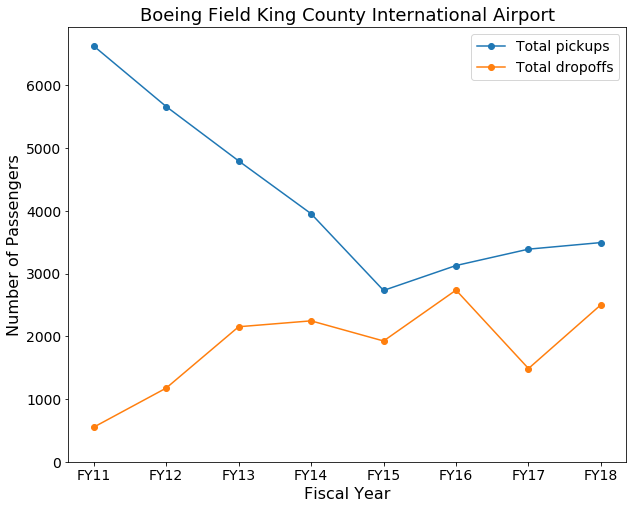

In [17]:
def pickup_dropoff_trend(data):
    
    fig, ax = plt.subplots()
    
    for datum in data:
        ax = datum.plot(style='o-', legend=True)
    
    ax.set_ylabel('Number of Passengers', fontsize=16)
    ax.set_ylim(0)
    ax.set_xticklabels([f'FY{str(x)[2:4]}' for x in range(2010,2019)])
    ax.set_xlabel('Fiscal Year', fontsize=16)
    ax.set_title(f'{airport_name}', fontsize=18)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14)
    
    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{airport}-ICE-Air-Passengers.png', dpi=100)
    return fig, ax

plot = pickup_dropoff_trend([annual_pickups['2010':'2017'], annual_dropoffs['2010':'2017']]);

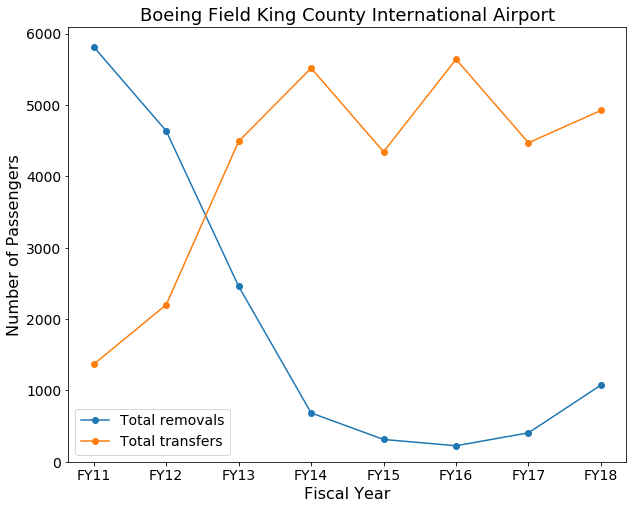

In [18]:
def removal_transfer_trend(data):
    
    fig, ax = plt.subplots()
    
    for datum in data:
        ax = datum.plot(style='o-', legend=True)
    
    ax.set_ylabel('Number of Passengers', fontsize=16)
    ax.set_ylim(0)
    ax.set_xticklabels([f'FY{str(x)[2:4]}' for x in range(2010,2019)])
    ax.set_xlabel('Fiscal Year', fontsize=16)
    ax.set_title(f'{airport_name}', fontsize=18)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14)
    
    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{airport}-ICE-Air-Removals-Transfers.png', dpi=100)
    return fig, ax

plot = removal_transfer_trend([annual_removals['2010':'2017'], annual_transfers['2010':'2017']]);

# Annual pickup rate, by criminal conviction status

WARNING: Criminal conviction data is not consistently recorded by ICE, especially in FY 11.

In [19]:
annual_non_criminal = pickup_df[['NonCriminal']].resample('AS-OCT').sum()

In [20]:
annual_non_criminal['total'] = annual_pickups
annual_non_criminal['percent'] = annual_non_criminal['NonCriminal']/annual_pickups*100

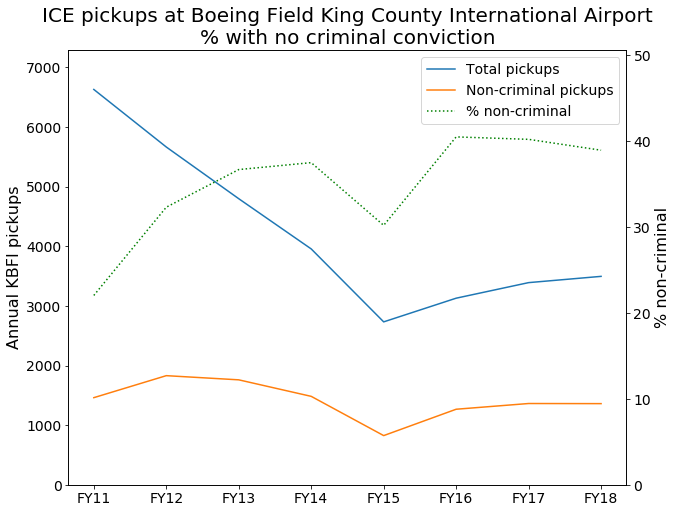

In [21]:
annual_data = annual_non_criminal['2010':'2017']
annual_data.index = [f'FY{str(x)[2:4]}' for x in range(2011,2019)]

plt.style.use([{'legend.frameon': True}])
plt.rc("font", family="Sans-Serif")

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

lns1 = ax1.plot(annual_data['total'], label='Total pickups')
lns2 = ax1.plot(annual_data['NonCriminal'], label='Non-criminal pickups')
ax1_max = annual_data['total'].max()
ax1.set_ylim(0, (ax1_max * 1.1))
ax1.set_ylabel(f'Annual {airport} pickups', fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

lns3 = ax2.plot(annual_data['percent'], label='% non-criminal', linestyle=':', color='green')
ax2_max = annual_data['percent'].max()
ax2.set_ylim(0, (ax2_max * 1.25))
ax2.set_ylabel('% non-criminal', fontsize=16)
ax2.tick_params(axis='y', labelsize=14)
# ax2.set_xticklabels([f'FY{str(x)[2:4]}' for x in range(2011,2019)])

lns = [lns1[0], lns2[0], lns3[0]]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0, fontsize=14)

ax1.set_title(f'ICE pickups at {airport_name}\n% with no criminal conviction', fontsize=20)

fig.set_size_inches(10, 8)

plt.show()
fig.savefig(f'../output/{airport}_NoCrim.png', dpi=100)

# Monthly averages (by calendar year)

Calculating average rates of pickups, dropoffs, and flights for each calendar year in the dataset.

Is this correct though? What we do below is calculate the mean of the monthly means for each year, which may not be right. We can just divide the yearly total by number of months to get monthly average.

Mean of means appears to be equivalent to total/number of months; at least it deals effectively with partial years.

In [22]:
pickup_df.groupby(pd.Grouper(freq='AS-OCT'))['AlienMasterID'].nunique()['2010':'2017']/12

MissionDate
2010-10-01    552.416667
2011-10-01    472.000000
2012-10-01    399.750000
2013-10-01    329.583333
2014-10-01    227.666667
2015-10-01    260.750000
2016-10-01    282.500000
2017-10-01    291.250000
Freq: AS-OCT, Name: AlienMasterID, dtype: float64

In [23]:
monthly_means = pd.DataFrame()
for year in range(2010, 2019):
    mean_pickups = monthly_pickups[f'{year}'].mean()
    mean_pickup_missions = monthly_pickup_missions[f'{year}'].mean()
    mean_dropoffs = monthly_dropoffs[f'{year}'].mean()
    mean_dropoff_missions = monthly_dropoff_missions[f'{year}'].mean()
    monthly_means = monthly_means.append({'calendar_year':year,
                                          'monthly_mean_pickups':mean_pickups,
                                          'monthly_mean_dropoffs':mean_dropoffs,
                                          'monthly_mean_pickup_missions':mean_pickup_missions,
                                          'monthly_mean_dropoff_missions':mean_dropoff_missions,
                                         }, ignore_index=True)
monthly_means['calendar_year'] = monthly_means['calendar_year'].astype(int)
monthly_means = monthly_means.set_index('calendar_year')

In [24]:
monthly_means.round(2)

,monthly_mean_dropoff_missions,monthly_mean_dropoffs,monthly_mean_pickup_missions,monthly_mean_pickups
calendar_year,,,,
2010,4.00,39.33,7.67,512.67
2011,4.42,59.00,8.33,544.17
2012,3.92,115.42,4.83,450.17
2013,3.17,165.25,4.08,383.58
2014,3.83,161.92,3.92,300.00
2015,3.17,209.00,2.83,237.67
2016,4.17,231.50,4.50,264.83
2017,3.50,120.92,4.25,288.50
2018,3.75,193.08,4.17,273.17


In [25]:
monthly_means.to_csv(f'../output/{airport}_monthly_means.csv')

# Top nationalities

In [26]:
pickup_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(10)

MEXICO                25133
GUATEMALA              3366
EL SALVADOR            2660
HONDURAS               2023
HAITI                   459
ECUADOR                 171
NICARAGUA               116
CAMBODIA                109
COLOMBIA                 51
DOMINICAN REPUBLIC       35
Name: CountryOfCitizenship, dtype: int64

In [27]:
dropoff_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(5)

EL SALVADOR    3430
GUATEMALA      2554
MEXICO         2278
HONDURAS       1786
INDIA          1513
Name: CountryOfCitizenship, dtype: int64

In [28]:
all_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(5)

MEXICO         27411
EL SALVADOR     6090
GUATEMALA       5920
HONDURAS        3809
INDIA           1543
Name: CountryOfCitizenship, dtype: int64

In [29]:
nat_percent = (df.groupby(['CountryOfCitizenship'])['AlienMasterID'].nunique() / len(df)).sort_values(ascending=False)

In [30]:
airport_nat_percent = (all_df.groupby(['CountryOfCitizenship'])['AlienMasterID'].nunique() / len(all_df)).sort_values(ascending=False)

In [31]:
pd.DataFrame({'Nationality as percent of dataset': nat_percent,
              f'Nationality as percent of {airport}': airport_nat_percent}).to_csv(f'../output/{airport}_nationality_percent_comparison.csv')

In [32]:
removal_nationalities = removal_df.groupby([pd.Grouper(freq='AS-OCT'), 'CountryOfCitizenship'])['AlienMasterID'].nunique().unstack()
removal_nationalities.to_csv(f'../output/{airport}_removal_nationalities.csv')

# Chart of top nationalities per year

This chart shows the top five `CountryOfCitizenship` values for each fiscal year. It can be misleading because values are summed in "ALL OTHERS" for years in which a particular nationalitiy is not in the top 5, but it makes clear things like which years certain groups come into or leave the top 5.

Charts can be generated for pickups, dropoffs, removals, transfers, or all records.

In [33]:
# Strangely, copying a DataFrame doesn't copy DataFrame.name
# There's probably a better way to link dataframes to downstream chart labels, though
df_to_analyze = all_df.copy()
df_to_analyze.name = all_df.name

In [34]:
g = df_to_analyze.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID', 'MissionID'].nunique()
country_of_citizenship_by_year = g.reset_index()
country_of_citizenship_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)
country_of_citizenship_by_year.set_index('FY', inplace=True)
country_of_citizenship_by_year.sort_values(by='AlienMasterID', ascending=False, inplace=True)

# country_of_citizenship_by_year.to_csv(f'../output/{airport}_country_of_citizenship_by_year.csv', index=True)

In [35]:
# Limiting to fiscal years with full data (FY2011-FY2018).
country_of_citizenship_by_year = country_of_citizenship_by_year['2010':'2017']

In [36]:
all_passenger_nationality_by_year = country_of_citizenship_by_year.groupby([pd.Grouper(freq='AS-OCT'),'CountryOfCitizenship'])[['AlienMasterID']].sum().dropna(how='all',axis=0).unstack()
# all_passenger_nationality_by_year.to_csv(f'../output/{airport}_all_passenger_nationality_by_year.csv')

In [37]:
top_5_df = pd.DataFrame()

for year in country_of_citizenship_by_year.index.unique():
    temp = country_of_citizenship_by_year.loc[f'{year}'][['CountryOfCitizenship', 'AlienMasterID']]
    temp_top_5 = temp[0:5]
    if len(temp) > 5:
        all_other_count = sum(temp['AlienMasterID'][5:])
    else:
        all_other_count = 0
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]], columns=['CountryOfCitizenship', 'AlienMasterID'], index=[year])
    temp_top_5 = temp_top_5.append(other_df)
    top_5_df = top_5_df.append(temp_top_5)
    
top_5_df.sort_index(inplace=True)
top_5_df.index = [f'FY{str(x)[2:4]}' for x in top_5_df.index.year + 1]

top_5_data = pd.pivot_table(data=top_5_df,
                       index=top_5_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

top_5_data = top_5_data.reindex(top_5_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_5_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_5_data = top_5_data[cols]

top_5_data.columns = top_5_data.columns.str.title()
top_5_data.columns.name = 'Country of Citizenship'

In [38]:
def country_of_citizenship_trend(data, title=str, filename=str, xlabel=str, ylabel=str):
    
    fig, ax = plt.subplots()
    
    data.plot(kind='bar', stacked=True, legend=True, ax=ax).legend(bbox_to_anchor=(1,1))

    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_title(title, fontsize=18)
    ax.tick_params(labelsize=14)
    plt.xticks(rotation=0)

    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{filename}.png', dpi=100, bbox_inches='tight')
    return fig, ax

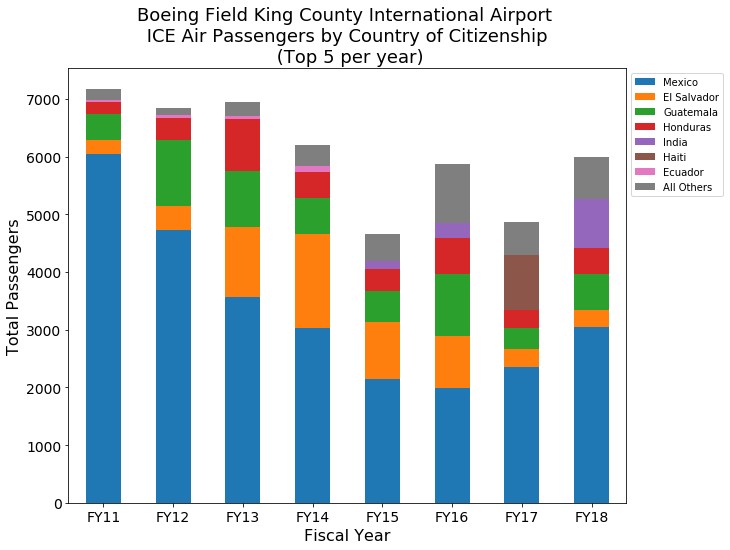

In [39]:
country_of_citizenship_trend(top_5_data,
                             title=f'{airport_name} \n ICE Air {df_to_analyze.name} by Country of Citizenship \n (Top 5 per year)',
                             filename=f'{airport}_top5_nationalities',
                             ylabel=f'Total {df_to_analyze.name}',
                             xlabel='Fiscal Year');

In [40]:
g = pickup_df.groupby(['PULOC', pd.Grouper(freq='AS-OCT', sort=True), 'air2_AirportName'])['AlienMasterID','MissionID'].nunique()
drop_locs_by_year = g.reset_index()
drop_locs_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)

# drop_locs_by_year.to_csv(f'../output/{airport}_drop_locs_by_year.csv', index=True)

# Alternate plot of top nationalities

Since selecting top 5 for each year is a bit counterintuitive, we can instead select here an aribtrary set of nationalities to display for all years, while summing others. This can be based on most common values or could be some other arbitrary list. (See also implementation in `global.ipynb` for plotting all values that break top 5 for any year.)

In [41]:
annual = df_to_analyze.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID'].nunique()

In [42]:
# There is probably a better way to do this
annual = annual.reset_index()
annual.set_index('MissionDate', inplace=True)

In [43]:
# Select arbitrary number of top values to display here
number_of_top_values = 6
annual_sum = annual.groupby(['CountryOfCitizenship'])['AlienMasterID'].sum()
top = list(annual_sum.sort_values(ascending=False).head(number_of_top_values).index)

top_df = pd.DataFrame()
top_df = top_df.append(annual[annual['CountryOfCitizenship'].isin(top)])
top_df.index = top_df.index.year

for year in annual.index.year.unique():
    temp = annual[f'{year}']
    temp2 = temp[~temp['CountryOfCitizenship'].isin(top)]
    all_other_count = temp2['AlienMasterID'].sum()
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]],
                            columns=['CountryOfCitizenship',
                                     'AlienMasterID'],
                            index=[year])
    top_df = top_df.append(other_df)

top_df.sort_index(inplace=True)
top_df.index = [f'FY{str(x)[2:4]}' for x in top_df.index + 1]

top_df['CountryOfCitizenship'] = top_df['CountryOfCitizenship'].astype('category')

top_data = pd.pivot_table(data=top_df,
                       index=top_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)
top_data = top_data.reindex(top_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_data = top_data[cols]
top_data.columns = top_data.columns.astype(str)
top_data.columns = top_data.columns.str.title()

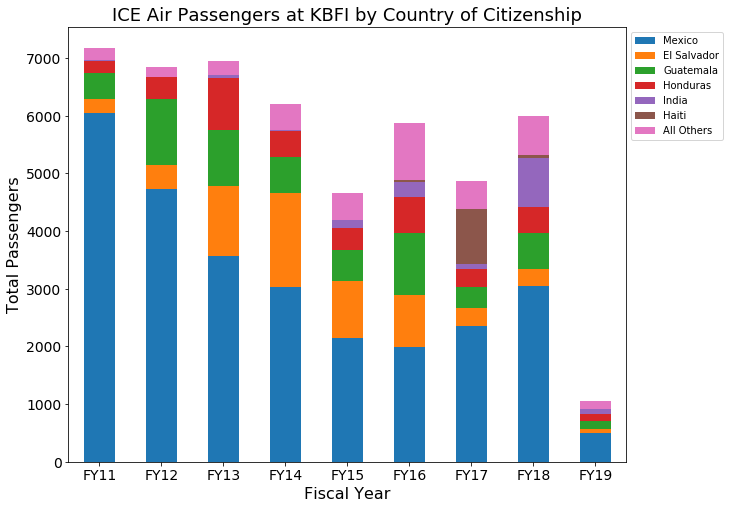

In [44]:
country_of_citizenship_trend(top_data,
                             title=f'ICE Air {df_to_analyze.name} at {airport} by Country of Citizenship',
                             filename=f'{airport}_pickup_nationalities',
                             ylabel=f'Total {df_to_analyze.name}',
                             xlabel='Fiscal Year');

# Juveniles (by fiscal year)

Table of just juveniles for pickups, dropoffs. Currently will fail if no juveniles.

In [45]:
assert sum(all_df['Juvenile']) > 0, f"No juveniles in dataset for {airport}"

In [46]:
g = pickup_df.groupby(['PULOC', pd.Grouper(freq='AS-OCT', sort=True), 'Juvenile'])['AlienMasterID'].nunique()
juvenile_pickups = g.unstack()
juvenile_pickups['percent'] = juvenile_pickups[True] / juvenile_pickups[False] * 100
juvenile_pickups

Juvenile            False  True   percent
PULOC MissionDate                        
KBFI  2010-10-01   6613.0  16.0  0.241948
      2011-10-01   5653.0  11.0  0.194587
      2012-10-01   4795.0   2.0  0.041710
      2013-10-01   3953.0   2.0  0.050594
      2014-10-01   2732.0   NaN       NaN
      2015-10-01   3129.0   NaN       NaN
      2016-10-01   3381.0   9.0  0.266193
      2017-10-01   3490.0   5.0  0.143266
      2018-10-01    652.0   NaN       NaN

In [47]:
g = dropoff_df.groupby(['DropLoc', pd.Grouper(freq='AS-OCT', sort=True), 'Juvenile'])['AlienMasterID'].nunique()
juvenile_pickups = g.unstack()

In [48]:
juvenile_pickups

Juvenile              False  True 
DropLoc MissionDate               
KBFI    2010-10-01    550.0    2.0
        2011-10-01   1172.0    3.0
        2012-10-01   2151.0    2.0
        2013-10-01   2177.0   70.0
        2014-10-01   1926.0    NaN
        2015-10-01   2737.0    NaN
        2016-10-01   1487.0    NaN
        2017-10-01   2504.0    NaN
        2018-10-01    410.0    NaN

In [49]:
juvenile_pickups['percent'] = juvenile_pickups[True] / juvenile_pickups[False] * 100
juvenile_pickups

Juvenile              False  True   percent
DropLoc MissionDate                        
KBFI    2010-10-01    550.0   2.0  0.363636
        2011-10-01   1172.0   3.0  0.255973
        2012-10-01   2151.0   2.0  0.092980
        2013-10-01   2177.0  70.0  3.215434
        2014-10-01   1926.0   NaN       NaN
        2015-10-01   2737.0   NaN       NaN
        2016-10-01   1487.0   NaN       NaN
        2017-10-01   2504.0   NaN       NaN
        2018-10-01    410.0   NaN       NaN

In [50]:
g = all_df.groupby(['R-T', pd.Grouper(freq='AS-OCT', sort=True), 'Juvenile'])['AlienMasterID'].nunique()

In [51]:
juvenile_removal_transfer = g.unstack()
juvenile_removal_transfer

Juvenile          False  True 
R-T MissionDate               
R   2010-10-01   5802.0   13.0
    2011-10-01   4629.0    9.0
    2012-10-01   2458.0    2.0
    2013-10-01    685.0    NaN
    2014-10-01    313.0    NaN
    2015-10-01    225.0    NaN
    2016-10-01    406.0    NaN
    2017-10-01   1071.0    4.0
    2018-10-01    452.0    NaN
T   2010-10-01   1361.0    5.0
    2011-10-01   2196.0    5.0
    2012-10-01   4488.0    2.0
    2013-10-01   5445.0   72.0
    2014-10-01   4345.0    NaN
    2015-10-01   5641.0    NaN
    2016-10-01   4462.0    9.0
    2017-10-01   4923.0    1.0
    2018-10-01    610.0    NaN

# Detainee status

In [52]:
status_count = removal_df.drop_duplicates(subset='AlienMasterID')['Status'].str.upper().value_counts()

In [53]:
status = pd.read_csv('../../share/resources/status.csv')

valid_status_codes = list(status['Code'])

status_dict = dict(zip(status['Code'], status['Status']))

problematic = ['2A', '2B', '5C', '5D', '5F', '8D']

In [54]:
problematic_count = 0
valid = removal_df['Status'].str.upper().isin(valid_status_codes)
valid_count = sum(valid)
invalid = ~removal_df['Status'].str.upper().isin(valid_status_codes)
invalid_count = sum(invalid)

print(f'{airport} - {airport_name}')
print()
print(f'ICE status codes for passengers on direct removal flights.')
print(f'(Statuses which may raise due process concerns starred)')
print()
print(f'{valid_count} valid values.')
print(f'{invalid_count} invalid values.')
print()
for c in valid_status_codes:
    
    try:
        count = status_count[c]
    except KeyError:
        count = 0
    
    if c in problematic:
        problematic_count = problematic_count + count
        print(f'[{c}]: *{count}* ({status_dict[c]})')
    else:
        print(f'[{c}]: {count} ({status_dict[c]})')
print()
print(f'{problematic_count} problematic cases.')

KBFI - Boeing Field King County International Airport

ICE status codes for passengers on direct removal flights.
(Statuses which may raise due process concerns starred)

5332 valid values.
10760 invalid values.

[1A]: 228 (Voluntary Departure – Un-Expired and Un-Extended Voluntary Departure.)
[1B]: 20 (Voluntary Departure - Extended Departure Period)
[1C]: 0 (Exipred Voluntary Departure Period - Referred to Investigation)
[2A]: *32* (Deportable – Under Adjudication by IJ)
[2B]: *1* (Deportable – Under Adjudication by BIA)
[3]: 161 (Deportable – Administratively Final Order)
[5A]: 1 (Referred for Investigation - No Show for Hearing - No Final O...)
[5B]: 20 (Removable – ICE Fugitive)
[5C]: *1* (Relief Granted – Withholding of Deportation/Removal)
[5D]: *1* (Final Order of Deportation/Removal – Deferred Action Granted.)
[5E]: 1 (Relief Granted – Extended Voluntary Departure)
[5F]: *0* (Unable to Obtain Travel Document)
[8A]: 31 (Excludable/Inadmissible – Hearing Not Commenced)
[8B]: 86 